In [1]:
import os
import random
import shutil

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image

import matplotlib.pyplot as plt

In [2]:
import multiprocessing as mp

def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # verify that it is, in fact, an image
        return False
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {image_path} - {e}")
        return True

def process_image(src_path, dest_dir, min_size=64):
    if not is_image_corrupted(src_path):
        with Image.open(src_path) as img:
            width, height = img.size
            if width >= min_size and height >= min_size:
                dest_path = os.path.join(dest_dir, os.path.basename(src_path))
                shutil.copy2(src_path, dest_path)

def copy_valid_images(src_dir, dest_dir, min_size=64, num_workers=mp.cpu_count()):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    image_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    src_paths = [os.path.join(src_dir, filename) for filename in image_files]

    with mp.Pool(processes=num_workers) as pool:
        pool.starmap(process_image, [(src_path, dest_dir, min_size) for src_path in src_paths])

# Define source and destination directories
src_dir = '/kaggle/input/animefacedataset/images'
dest_dir = '/kaggle/working/images/images'

In [3]:
# Copy valid images
copy_valid_images(src_dir, dest_dir)

In [4]:
def load_images_from_directory(directory, num_images=64):
    images = []
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) < num_images:
        raise ValueError(f"Not enough images in the directory. Found {len(image_files)} images, but need {num_images}.")
    
    selected_files = random.sample(image_files, num_images)
    
    for filename in selected_files:
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((64, 64))  # Resize to 64x64 if needed
        images.append(img)
    
    return images

def create_image_grid(images, grid_size=(8, 8)):
    num_rows, num_cols = grid_size
    assert len(images) == num_rows * num_cols, "Number of images must match the grid size."
    
    # Create a blank image to hold the grid
    grid_image = Image.new('RGB', (num_cols * 64, num_rows * 64))
    
    for i, img in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        grid_image.paste(img, (col * 64, row * 64))
    
    return grid_image

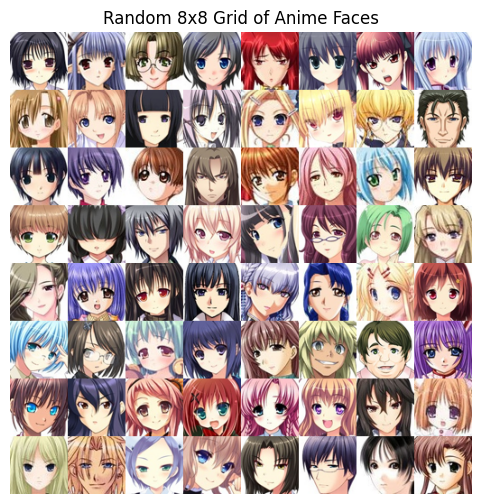

In [5]:
grid_size = (8, 8)
num_images = grid_size[0] * grid_size[1]

images = load_images_from_directory(dest_dir, num_images)
grid_image = create_image_grid(images, grid_size)

# Convert the grid image to a NumPy array for matplotlib
grid_array = np.array(grid_image)

# Display the grid using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(grid_array)
plt.axis('off')  # Turn off axis labels
plt.title('Random 8x8 Grid of Anime Faces')
plt.show()

In [6]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)
])

In [8]:
# Load the dataset
dataset = ImageFolder(root="/".join(dest_dir.split("/")[:-1]), transform=transform)

# Create a data_loader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())

In [9]:
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Define the Convolutional Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, img_shape[0], 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(z)
        return img

# Define the Convolutional Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(validity.size(0), -1)

# Hyperparameters
latent_dim = 256
img_shape = (3, 64, 64)
n_critic = 5
clip_value = 0.01
n_epochs = 500
lr = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Generator and Discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

In [10]:
# Checkpoint file path
checkpoint_path = 'checkpoint.pth'

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    start_epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    start_epoch = 0
    g_losses = []
    d_losses = []

Loaded checkpoint from epoch 215


<ipython-input-10-4fdcaf14b83a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
from tqdm import tqdm

# Training Loop
for epoch in range(start_epoch, n_epochs):
    g_epoch_loss = 0.0
    d_epoch_loss = 0.0
    with tqdm(total=len(data_loader)) as pbar:
        for i, (imgs, _) in enumerate(data_loader):
            # Configure input
            real_imgs = imgs.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.shape[0], latent_dim).to(device)

            # Generate a batch of images
            fake_imgs = generator(z).detach()

            # Adversarial loss
            loss_D = -(torch.mean(discriminator(real_imgs)) - torch.mean(discriminator(fake_imgs)))
            loss_D.backward()
            optimizer_D.step()

            # Clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # Train the generator every n_critic iterations
            if i % n_critic == 0:
                # Train Generator
                optimizer_G.zero_grad()

                # Generate a batch of images
                gen_imgs = generator(z)

                # Adversarial loss
                loss_G = -torch.mean(discriminator(gen_imgs))
                loss_G.backward()
                optimizer_G.step()
                
                g_epoch_loss += loss_G.item()
                
            d_epoch_loss += loss_D.item()

            # Update progress bar
            pbar.set_postfix({'D Loss': loss_D.item(), 'G Loss': loss_G.item()})
            pbar.update(1)

        # Store average losses for the epoch
        g_losses.append(g_epoch_loss / (len(data_loader) // n_critic))
        d_losses.append(d_epoch_loss / len(data_loader))

        # Print and save generated images
        save_image(gen_imgs.data[:25], f"{epoch}.png", nrow=5, normalize=True)

         # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'g_losses': g_losses,
            'd_losses': d_losses
        }
        torch.save(checkpoint, checkpoint_path)

 91%|█████████ | 816/895 [00:40<00:04, 19.57it/s, D Loss=-0.000512, G Loss=0.0077]   

In [ ]:
# Save the generator
torch.save(generator.state_dict(), 'generator.pth')
print("Generator model saved.")

In [ ]:
# Plot the loss evolution
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Load the saved generator
generator = Generator(latent_dim, img_shape).to(device)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()  # Set the generator to evaluation mode

In [ ]:
from torchvision.utils import make_grid
# Generate 64 images
n_images = 64
z = torch.randn(n_images, latent_dim).to(device)
with torch.no_grad():
    generated_images = generator(z)

# Create a grid of images
grid = make_grid(generated_images, nrow=8, normalize=True).permute(1, 2, 0)

# Convert the grid to a NumPy array for display
grid_np = grid.cpu().numpy()

In [ ]:
# Display the images using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.show()